lien pas mal sur eigenmaps: https://www.youtube.com/watch?v=BgMFBqrtCwo

**J'ai tenté plusieurs trucs. Actuellement, il faudrait en priorité faire un airport_in_bg2 pour virer plein de variables redondantes (et pas forcément 100% justes). Poursuivre l'algorithme de vérification aussi. A ce sujet, au vu de ce qu'est l'Inde, l'Atlantique et autres mini clusters je pense qu'on peut éventuellement les drop car on les récupèrera jamais en faisant du clustering. Soit on les ignore et le clustering les mettra dans un cluster européen, américain ou autre, soit on les vire mais faudrait éviter sachant qu'on a déjà viré près de 200 noeuds. J'ai aussi commenté certains blocs inutiles mais à terme on aura beaaaaaaaucoup de lignes inutiles à virer, car beaucoup de variables seront inutiles :p**

**Plusieurs pistes pour le projet déjà explorées mais pas convaincantes à l'heure actuelle (entre autres à cause des trucs qui s'avèrent être faux) :**

**1 - kmeans peut prendre pas mal de paramètres, dont un set de centres initiaux pour le clustering. ça fait effet pour avoir testé. Par contre, il faudrait trouver des infos qui relient à des aéroports bien choisis (genre le plus gros de chaque continent) et mettre ça en init. Plus bas il y a node_tuned, ce sont les noeuds initiaux (la plupart les gros hubs, sinon des noeuds bien choisis).**

**2 - en supprimant la ligne edges.drop_duplicates() on peut modifier les poids aussi en fonction du trafic entre deux aéroports (en faisant weighted_matrix_inv[i, j] += np.exp(-dist/sigma)), ça peut rapprocher artificiellement deux aéroports ultraconnectés mais je ne sais pas si c'est ouf vu que ça devrait rapprocher des gros aéroports éloignés**

**3 - Il existe un truc qui s'appelle community qui a l'air stylé par rapport au rendu de kmeans (http://cjauvin.blogspot.com/2014/03/k-means-vs-louvain.html) mais j'ai pas réussi à l'installer correctement. Ce site (https://bitbucket.org/taynaud/python-louvain/issues/23/module-has-no-attribute-best_partition) peut aider à installer en installant python-louvain a la mano mais je suis une quiche pour faire ça haha**

# [NTDS'18] Project
[ntds'18]: https://github.com/mdeff/ntds_2018

## Students

* Team: 3
* Students: Baptiste Hériard-Dubreuil, Jean-Baptiste Membrado, Guilhem Noiraud, Amaury Véron
* Dataset: Flight routes

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers
import networkx as nx
from sklearn.cluster import KMeans
import folium

### Add geographic coordinates to our features

*Dataset of routes*

In [3]:
features = pd.read_csv("routes.dat", names = ["airline",
                                              "airline_id",
                                              "source_airport",
                                              "source_airport_id",
                                              "destination_airport",
                                              "destination_airport_id",
                                              "codeshare",
                                              "stops",
                                              "equipment"])
features.head()

,airline,airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


*Get nodes and edges*

In [4]:
source_airports = features[["source_airport_id", "source_airport"]]
source_airports.columns = ["airport_id", "airport"]

destination_airports =  features[["destination_airport_id", "destination_airport"]]
destination_airports.columns = ["airport_id", "airport"]

nodes = pd.concat([source_airports,destination_airports], axis = 0).drop_duplicates()
nodes.replace(to_replace='\\N', value=np.NaN, inplace=True)
nodes.dropna(axis=0, inplace=True)
nodes["airport_id"] = nodes["airport_id"].apply(int)   #Convert IDs to int to allow merge

edges = features[["source_airport_id", "destination_airport_id"]]
edges = edges.replace(to_replace='\\N', value=np.NaN)
edges = edges.dropna(axis=0)
edges["source_airport_id"] = edges["source_airport_id"].apply(int)   #Convert IDs to int to allow merge
edges["destination_airport_id"] = edges["destination_airport_id"].apply(int)   #Convert IDs to int to allow merge

nodes.head()

,airport_id,airport
0,2965,AER
1,2966,ASF
3,2968,CEK
5,4029,DME
9,6156,EGO


In [5]:
edges.head()

,source_airport_id,destination_airport_id
0,2965,2990
1,2966,2990
2,2966,2962
3,2968,2990
4,2968,4078


*Dataset of information about airports*

In [6]:
airports = pd.read_csv("airports.dat", names = ["airport_id", "Name", "City", "Country", "IATA", "ICAO", "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabase", "Type", "Source"])

In [7]:
airports.head()

,airport_id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzDatabase,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


*Add Latitudes and Longitudes to nodes DataFrame*

In [8]:
nodes = nodes.merge(airports[["airport_id", "Latitude", "Longitude", "TzDatabase"]], how='left', on='airport_id')
nodes["TzDatabase"] = nodes["TzDatabase"].apply(lambda x: str(x).split("/")[0])
nodes.columns = ["airport_id", "airport", "Latitude", "Longitude", "Continent"]
nodes.set_index("airport_id", inplace=True)

In [9]:
nodes.head()

,airport,Latitude,Longitude,Continent
airport_id,,,,
2965,AER,43.449902,39.956600,Europe
2966,ASF,46.283298,48.006302,Europe
2968,CEK,55.305801,61.503300,Asia
4029,DME,55.408798,37.906300,Europe
6156,EGO,50.643799,36.590099,Europe


In [10]:
#REVOIR PTETRE MIEUX

nodes.dropna(inplace=True)

*Convert airports IDs to node index*

In [11]:
# Conversion table from airport_id to node index.
airport_id2idx = pd.DataFrame(nodes.index.unique())
airport_id2idx.reset_index(level = 0, inplace = True)
airport_id2idx.columns = ["node_idx", "airport_id"]
airport_id2idx.set_index("airport_id", inplace = True)
airport_id2idx.head()

,node_idx
airport_id,
2965,0
2966,1
2968,2
4029,3
6156,4


In [12]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "source_airport_id",
                 right_index = True,
                 sort = False)

In [13]:
edges = pd.merge(edges, airport_id2idx,
                 left_on = "destination_airport_id",
                 right_index = True,
                 sort = False,
                 suffixes = ("_source", "_destination"))

edges = edges.drop_duplicates()  # Avoid multilinks

In [14]:
edges.head()

,source_airport_id,destination_airport_id,node_idx_source,node_idx_destination
0,2965,2990,0,7
1,2966,2990,1,7
3,2968,2990,2,7
5,4029,2990,3,7
10,6156,2990,4,7


*Create adjacency matrix*

In [15]:
n_nodes = nodes.shape[0]

*Create weighted matrix*

In [16]:
#Weighted matrix with heat kernel as weights

sigma = 1751 #1751 = mean distance, sigma is tunable and changes the results
weighted_matrix_inv = np.zeros((n_nodes, n_nodes))

dists = []

for idx, row in edges.iterrows():
    i, j = int(row.node_idx_source), int(row.node_idx_destination)
    
    if i != j:
        source_coords = (nodes.loc[row.source_airport_id]["Latitude"], nodes.loc[row.source_airport_id]["Longitude"])    
        dest_coords = (nodes.loc[row.destination_airport_id]["Latitude"], nodes.loc[row.destination_airport_id]["Longitude"])
        dist = distance.geodesic(source_coords, dest_coords).km
        dists.append(dist)
        weighted_matrix_inv[i, j] = np.exp(-dist/sigma)
        
mean_dist = sum(dists)/len(dists)

# Make it symmetric
for i in range(n_nodes):
    for j in range(n_nodes):
        if weighted_matrix_inv[i][j] != 0:
            weighted_matrix_inv[j][i] = weighted_matrix_inv[i][j]

In [17]:
mean_dist

1751.1430666840702

*Create weighted matrix for heat kernel for biggest cluster*

In [18]:
df_biggest_cluster = pd.read_csv("df_biggest_cluster.csv")
df_biggest_cluster.set_index("airport_id", inplace=True)

In [19]:
airport_in_bg = np.array(df_biggest_cluster.columns)

#Check Latitude and Longitude are known. Not considered if not
airport_in_bg = np.array([int(airport_in_bg[i]) for i in range(len(airport_in_bg)) if int(airport_in_bg[i]) in airport_id2idx.index])

In [20]:
#Breadth first search algorithm

#Remark : the BFS compute the shortest path for the hop-distance

def bfs(adjacency, start_node):
    distance_from_start_node = np.Inf * np.ones(adjacency.shape[0])   # Unlabelled are set to inf
    distance_from_start_node[start_node] = 0
    queue = [(start_node, 0)]
    
    while queue:
        current_node = queue.pop(0)
        link_nodes = link_nodes_unlabelled(adjacency, current_node, distance_from_start_node)
        for node in link_nodes:
            distance_from_start_node[node[0]] = node[1]
        queue += link_nodes
    
    return distance_from_start_node

#Function that returns new nodes linked to current_node and their hop-distance to origin.

def link_nodes_unlabelled(adjacency, current_node, distance_from_start_node):
    link_nodes = []
    for idx in range(adjacency.shape[0]):
        if adjacency[current_node[0],idx] > 0 and distance_from_start_node[idx] == np.Inf:
            link_nodes.append((idx, current_node[1]+1))     # Add unlabelled nodes linked to the current node with label +1
    return link_nodes

In [21]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    components = []
    n_nodes = adjacency.shape[0]
    n = 1
    unseen_nodes = [i for i in range(n_nodes)]
    a=[]
    while unseen_nodes:
        connected_components = []
        current_node = np.random.choice(unseen_nodes)   # Choose a random unseen node
        distance_from_start_node = bfs(adjacency, current_node)  # Compute BFS from this node
        
        for idx, dist in enumerate(distance_from_start_node):
            if dist != np.Inf:     # The connected nodes (from a source) are the labelled nodes !
                connected_components.append(idx)
        
        unseen_nodes = [e for e in unseen_nodes if e not in connected_components] # Update unseen nodes
        a.append(connected_components)
    return a

In [22]:
bg_indices = find_components(weighted_matrix_inv)[0]

In [23]:
bg_heat = weighted_matrix_inv[:,bg_indices][bg_indices,:]
n_nodes_bg = len(bg_heat)
n_nodes_bg

3154

In [24]:
#Check the connected components of heat_bg2
len(sorted(nx.connected_component_subgraphs(nx.from_numpy_matrix(bg_heat)), key = len, reverse=True))

1

*Little tests*

In [25]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [26]:
check_symmetric(bg_heat)

True

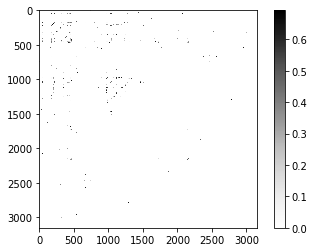

In [27]:
#Plot of the distances
plt.imshow(np.log(bg_heat + 1),cmap = 'Greys')
plt.colorbar()

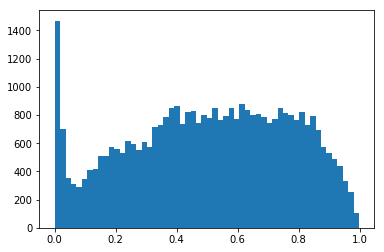

In [28]:
# Plot distribution of inverse distances
values = []

for i in range(n_nodes_bg):
    for j in range(n_nodes_bg):
        if bg_heat[i][j] != 0:
            values.append(bg_heat[i][j])
            
plt.hist(values, bins = int(np.sqrt(n_nodes_bg)));

In [29]:
#ground truth
dic = {"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"\\N":10,np.nan:10}

labels = nodes.Continent
labels = np.array(labels.replace(dic).tolist())

In [30]:
#https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
dic_color = {0: '#e6194b',
             1: '#3cb44b',
             2: '#ffe119',
             3: '#4363d8',
             4: '#f58231',
             5: '#911eb4',
             6: '#46f0f0',
             7: '#f032e6',
             8: '#bcf60c',
             9: '#fabebe',
             10: '#008080',
             11: '#e6beff',
             12: '#9a6324',
             13: '#000000',
             14: '#800000',
             15: '#aaffc3',
             16: '#808000',
             17: '#ffd8b1',
             18: '#000075',
             19: '#808080'
}

In [31]:
#labels for bg_heat2, c'est faux comme méthode faudrait faire un airport_in_bg2_idx
#avec ça il y a environ 20 neuds mal faits

labels_bg = labels[bg_indices]
        
ground_truth = [dic_color[labels_bg[i]] for i in range(len(labels_bg))]

In [32]:
#nan are changed to the color of the nearest neighbour

gt_without_nan = ground_truth.copy()
for i in range(len(ground_truth)):
    if gt_without_nan[i] == '#008080': #nan color
        weight = 0
        index_min = 0
        for j in range(len(ground_truth)-1):
            if (gt_without_nan[j]!='#008080') and bg_heat[i][j]>weight:
                weight = bg_heat[i][j]
                index_min = j
        gt_without_nan[i] = gt_without_nan[index_min]

In [33]:
print([(i, labels.tolist().count(i)) for i in set(labels)]) #label repartition for weighted_matrix_inv

[(1, 1225), (2, 769), (3, 561), (4, 258), (5, 175), (6, 112), (7, 32), (8, 29), (9, 1), (10, 24)]


In [34]:
print([(i, labels_bg.tolist().count(i)) for i in set(labels_bg)]) #label repartition for bg_heat2

[(1, 1209), (2, 767), (3, 561), (4, 254), (5, 165), (6, 112), (7, 32), (8, 29), (9, 1), (10, 24)]


### Laplacian eigenmaps tests

In [35]:
# #Test with "eigenvectors" L*u = lambda*D*u

# laplacian_norm, D = sparse.csgraph.laplacian(weighted_matrix_inv, normed=True, return_diag=True)
# D = np.diag(D)

# computation_norm =  scipy.linalg.eigh(laplacian_norm)  #Compute orthonormale basis
# eigenvectors_norm = computation_norm[1]
# eigenvalues_norm =  computation_norm[0]

# #Sort to have ordered eigenvalues
# idx_norm = eigenvalues_norm.argsort()  
# eigenvalues_norm = np.round_(np.real(eigenvalues_norm[idx_norm]), 13)
# eigenvectors_norm = np.real(eigenvectors_norm[:,idx_norm])

# eigenvectors_u = np.linalg.inv(D)@eigenvectors_norm
# eigenvalues_u = eigenvalues_norm

In [36]:
#Test with "eigenvectors" L*u = lambda*D*u
#Laplacian norm for bg_heat

laplacian_norm_bg, D = sparse.csgraph.laplacian(bg_heat, normed=True, return_diag=True)
D = np.diag(D)

computation_norm_bg =  scipy.linalg.eigh(laplacian_norm_bg)  #Compute orthonormale basis
eigenvectors_norm_bg = computation_norm_bg[1]
eigenvalues_norm_bg =  computation_norm_bg[0]

#Sort to have ordered eigenvalues
idx_norm_bg = eigenvalues_norm_bg.argsort()  
eigenvalues_norm_bg = np.round_(np.real(eigenvalues_norm_bg[idx_norm_bg]), 13)
eigenvectors_norm_bg = np.real(eigenvectors_norm_bg[:,idx_norm_bg])

eigenvectors_u_bg = np.linalg.inv(D)@eigenvectors_norm_bg
eigenvalues_u_bg = eigenvalues_norm_bg

In [37]:
#Find the max degree node of each label

max_degree = np.zeros(10, dtype = int)
node_rank = np.zeros(10, dtype = int)

for i in range(n_nodes_bg):
    degree = sum(bg_heat[i]>0)
    if degree > max_degree[labels_bg[i]-1]:
        max_degree[labels_bg[i]-1] = degree
        node_rank[labels_bg[i]-1] = i

In [38]:
node_rank

array([ 186,  291,  211,  216, 1152,  296,   54, 1476, 1991,  244])

In [39]:
Y = eigenvectors_u_bg[:, 1:3] #Could be more than 2 eigenvectors

In [40]:
#"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"nan":10

node_tuned = node_rank.copy()

#node_tuned[1] = 1061
#node_tuned[3] = 225
#node_tuned[4] = 1859
node_tuned[5] = 2299 #validé
node_tuned[6] = 2292 #validé
#node_tuned[7] = 2494

In [41]:
Y_init = np.array([Y[node_tuned[i]].tolist() for i in range(8)])

In [42]:
#Clustering
#Il est possible de donner les centres initiaux des clusters, ça ne marche pas top actuellement car
#labels2 est faux, pas sûr que ça marche bien pour autant par la suite.
kmeans = KMeans(n_clusters=8, init=Y_init) 
kmeans.fit(Y)

/home/baptiste/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


KMeans(algorithm='auto', copy_x=True,
    init=array([[-0.0096 ,  0.00078],
       [ 0.00688,  0.00046],
       [ 0.00333, -0.00361],
       [ 0.00338, -0.00365],
       [-0.00668,  0.00462],
       [ 0.00669,  0.00032],
       [ 0.00292, -0.00355],
       [ 0.00481, -0.00309]]),
    max_iter=300, n_clusters=8, n_init=10, n_jobs=None,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [43]:
lab = kmeans.labels_

In [44]:
lab_color = [dic_color[lab[i]] for i in range(len(lab))]

In [45]:
#label to plot one point on the map

lab_empty = np.zeros(len(labels_bg))
lab_empty[225] = 1 #number of the node you want to see
lab_test = [dic_color[lab_empty[i]] for i in range(len(lab_empty))]

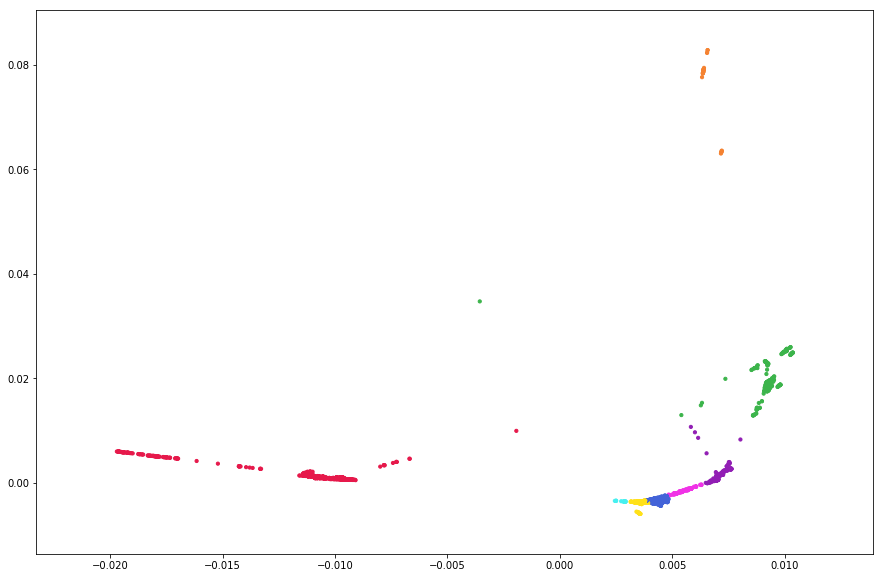

In [46]:
#Plot on the first two eigenvectors
plt.figure(figsize=(15,10))
plt.scatter(Y[:,0],Y[:,1], s=10, c=lab_color, cmap='rainbow')  
plt.show()

In [47]:
nodes_bg = nodes.iloc[bg_indices]   #get nodes in biggest_cluster

In [48]:
#Creation of the map (called mapit). You can visualize it by opening the file on Internet
mapit = folium.Map(tiles="Mapbox Bright")
j = 0
corr = 0



#C'est faux comme code pour ploter bg_heat2, faudrait refaire nodes_bg en un nouveau nodes_bg2 qui va bien
#plot nodes
for i in nodes_bg.iterrows():
    coord = [i[1].Latitude, i[1].Longitude]
    folium.CircleMarker( location=coord, radius=1, color=lab_color[j], fill=True).add_to( mapit )

#     folium.CircleMarker( location=coord, radius=1, color=ground_truth[j], fill=True).add_to( mapit )
    j += 1

# #plot edges. Comment t go faster
# coords = np.zeros((max(nodes.index)+1,2))
# for i in nodes.iterrows():
#     coords[i[0]] = (i[1].Latitude, i[1].Longitude)

# #plot edges 
# for i in edges.iloc[:].iterrows():
#     my_edge = [coords[i[1].source_airport_id], coords[i[1].destination_airport_id]]
#     folium.vector_layers.PolyLine(my_edge, color="black", weight=0.5, opacity=0.5).add_to( mapit )              

In [49]:
mapit.save('mapit.html')

### Computing the error between ground truth and our prediction

The idea is to compute the percentage of good predictions we can get from our model compared to the ground truth labels i.e how many airports are correclty labelled in percentage.
Correctly labelled means that the cluster in which the airport is attributed is the true continent label of the airport.

The problem is that K-Means produce several clusters randomly : if we compute 10 clusters, we cannot easily associate each one to a continent to compare.
For example : if a cluster is formed on the basis of Europe and Africa, what continent should it be associated to ?

One possible idea is to choose keys of the continents that will represent their clusters. We can say that if we take Paris as the key to Europe, we compare the cluster in which Paris is, and the continent Europe. This method is not flawless, but can serve as a way to begin the experiments on finding a good loss function for our optimization. The aim is to automatize this process which is time-consuming and imprecise.

The continent labels we have are : 
"America":1, "Asia":2,"Europe":3,"Africa":4,"Pacific":5,"Australia":6,"Atlantic":7,"Indian":8,"Arctic":9,"\\N":10

Keys for the continents :

America = Minneapolis

Asia = Seoul

Europe = Geneva (très bizarre, ça ne marche ni pour Toulouse, ni pour Paris :()

Africa = Cape Town

Pacific = Papeete

Australia = Brisbane

Atlantic = Ponta Delgada

Indian = Mumbai

Arctic = Svalbard (the only one in Arctic)

\N = Agartha TMTC


In [50]:
# Finding the keys for the continents

key_city = ["Minneapolis", "Seoul", "Geneva", "Cape Town", "Papeete", "Sydney", "Ponta Delgada", "Mumbai", "Svalbard"]
name_continent = ["America", "Asia", "Europe", "Africa", "Pacific", "Australia", "Atlantic", "Indian", "Arctic"]
n_continent = len(key_city)
key_index = np.zeros(n_continent)

# Let us find the keys of the index cities

for i in range(len(airports.City)):
    for continent in range(n_continent):
        if (airports.City[i] == key_city[continent]):
            key_index[continent] = i

In [51]:
airports.TzDatabase[key_index]

3638.0        America/Chicago
3705.0             Asia/Seoul
1621.0           Europe/Paris
780.0     Africa/Johannesburg
3833.0         Pacific/Tahiti
3155.0       Australia/Sydney
1590.0        Atlantic/Azores
2837.0          Asia/Calcutta
649.0     Arctic/Longyearbyen
Name: TzDatabase, dtype: object

In [52]:
key_index

array([3638., 3705., 1621.,  780., 3833., 3155., 1590., 2837.,  649.])

In [53]:
latitude_R = airports.Latitude[key_index]
longitude_R = airports.Longitude[key_index]

# Finding the corresponding indexes in the new eigenmaps

new_index = np.empty(n_continent)

for i in range(n_nodes_bg):
    for c, key_idx in enumerate(key_index):
        if ((round(nodes.Latitude.values[bg_indices[i]],2) == round(latitude_R[key_idx], 2)) and (round(nodes.Longitude.values[bg_indices[i]],2) == round(longitude_R[key_idx], 2))):
            new_index[c] = i
            
new_index = new_index.astype(int)

In [54]:
# Ne marche pas encore bien
labels

array([3, 3, 2, ..., 2, 1, 1])

In [55]:
labels = lab[new_index]
# We can now compare the airports in the cluster associated with the true labels

# Percentage of the European airports that are well recognized :
total_airports = np.zeros(n_continent)
score_airports = np.zeros(n_continent)

for i in range(n_nodes_bg):
    for continent, continent_idx in enumerate(new_index):
        if(nodes.Continent.values[bg_indices[i]] == name_continent[continent]):
            total_airports[continent]+=1
            if(lab[i] == labels[continent]):
                score_airports[continent]+=1

In [56]:
Arctic = [i for i in range(n_nodes_bg) if(nodes.Continent.values[i] == "Arctic")]

In [57]:
#Percentage of correct guesses :
(score_airports/total_airports)*100
final_score = np.zeros(n_continent)

for i in range(n_continent):
    final_score[i] = round(score_airports[i]/total_airports[i], 2)*100
    print("Score for ", name_continent[i], " : ",final_score[i])

Score for  America  :  98.0
Score for  Asia  :  57.99999999999999
Score for  Europe  :  96.0
Score for  Africa  :  56.99999999999999
Score for  Pacific  :  18.0
Score for  Australia  :  99.0
Score for  Atlantic  :  53.0
Score for  Indian  :  21.0
Score for  Arctic  :  100.0


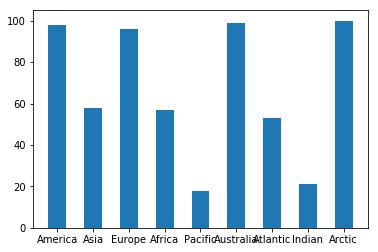

In [58]:
plt.bar(name_continent, final_score, width = 0.5);

### Plot graph with networkx

/home/baptiste/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


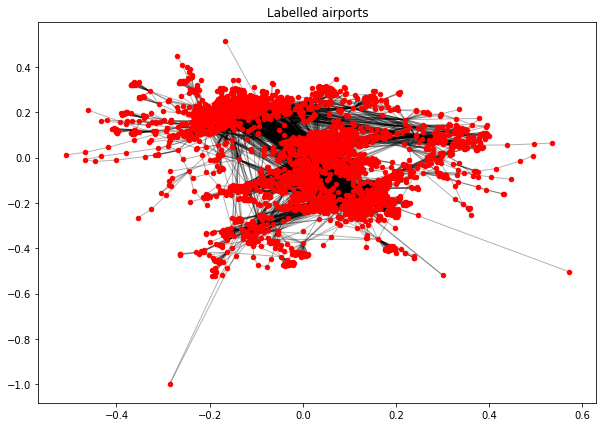

In [59]:
graph = nx.from_numpy_matrix(bg_heat)
coords = nx.spring_layout(graph)

plt.figure(figsize=(10,7))
nc = nx.draw_networkx_nodes(graph, coords, node_size=20, cmap=plt.cm.jet)
nx.draw_networkx_edges(graph, coords, alpha=0.3)
plt.title("Labelled airports");